In [18]:

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import argparse
from src.config import Config

from src.utils import create_generator
from src.dataset import CellDataset, categories, InfiniteSamplerWrapper


from glob import glob
import os
import cv2
from skimage import img_as_float32

import matplotlib.pyplot as plt


In [2]:
# latent_dims = 128
# parser = argparse.ArgumentParser(description="Configuration")
# parser.add_argument('--config', type=str, default='default_config', help='configuration filename')
# args = parser.parse_args()
config = Config(filename='default_config', mode='test')

In [3]:
netG = create_generator(config).cuda()
netG.eval()

Generator(
  (cls_map_net): EmbeddingNetwork(
    (net): Sequential(
      (0): Linear(in_features=15, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (init_z): InitLayer(
    (init): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (up_8): UpBlock(
    (main): CondEmbedSequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): AdaIN(
        (param_free_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (affine_cond): Linear(in_features=128, out_features=1024, bias=True)
      )
      (2): L

In [22]:
config.data_dir

In [48]:
class Train_dataset(torch.utils.data.Dataset):
    def __init__(self, transform, mode='train'):
        self.images = glob(os.path.join('/home/yoos-bii/Desktop/data_tct', mode, '*/*.png'))
        
        self.transform = transform    

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # [B, G, R] --> [R, G, B]
        img = img_as_float32(img)   
        lbl = self.images[idx].split('/')[-2]
        
        if self.transform: 
            img = self.transform(img)
        
        return img, lbl 

In [49]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256))
])

In [50]:
train_dataset = Train_dataset(transform)

In [51]:
# train_loader = torch.utils.data.DataLoader(
#     '/home/yoos-bii/Desktop/data_tct/val', batch_size=1, shuffle=True, 
    
# )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [4]:
# img, label = next(iter(train_loader))
# img.shape, lbl.shape
# lbl
# type(label)

eval_categories = list(categories.keys())
eval_categories

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14']

In [10]:
label = torch.tensor(categories['1']).unsqueeze(0).cuda().float()
label, type(label)

(tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
        device='cuda:0'),
 torch.Tensor)

In [37]:
with torch.no_grad():
    noise = torch.randn(1, config.LATENT_DIMS).cuda().float()
    gen_img = netG(noise, label)

In [41]:
gen_img_numpy = gen_img.cpu().numpy()
gen_img_numpy.shape

(1, 3, 256, 256)

(array([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 3.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 0., 0., 2., 2.,
        1., 5., 1., 2., 1., 0., 2., 2., 1., 2., 6., 4., 3., 1., 2., 2., 7.,
        2., 3., 0., 2., 2., 3., 2., 1., 3., 1., 6., 1., 3., 1., 2., 4., 2.,
        2., 3., 1., 0., 3., 2., 0., 1., 3., 0., 0., 2., 2., 3., 1., 1., 1.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-2.54183197, -2.49531937, -2.44880652, -2.40229392, -2.35578108,
        -2.30926847, -2.26275563, -2.21624303, -2.16973019, -2.12321758,
        -2.07670474, -2.03019214, -1.98367929, -1.93716669, -1.89065397,
        -1.84414124, -1.79762852, -1.7511158 , -1.70460308, -1.65809035,
        -1.61157763, -1.56506491, -1.51855218, -1.47203946, -1.42552674,
        -1.37901402, -1.33250129, -1.28598857, -1.23947585, -1.19296312,
        -1.1464504 , -1.09993768, -1.05342495, -1.00691223, -0.96039957,
        -0.91388685, -0.86737412, -0.82

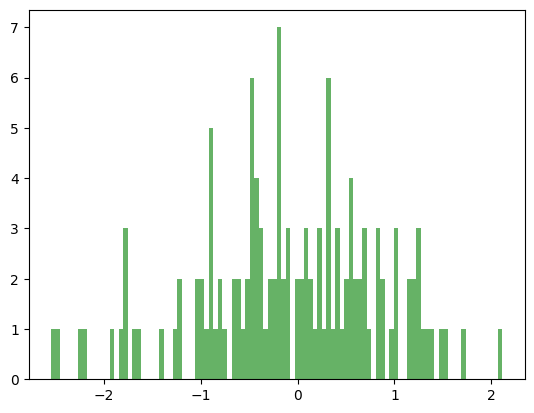

In [46]:
noise_numpy = noise.cpu().numpy()
# plt.imshow(noise_numpy[0])
# plt.imshow(noise_numpy[1])
plt.hist(noise_numpy[0].flatten(), bins=100, alpha=0.6, color='g')

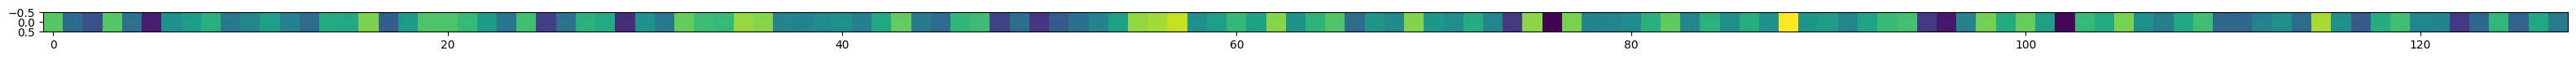

In [55]:
plt.figure(figsize=(40, 10))
plt.imshow(noise_numpy)

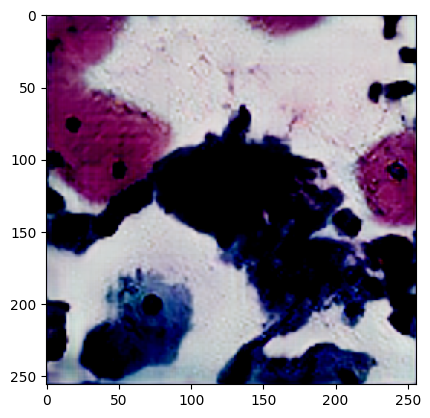

In [43]:
plt.imshow(gen_img_numpy[0].transpose(1, 2, 0))

In [71]:
from PIL import Image
import imagehash

def find_similar_images(img_path, img_dir):
    target_hash = imagehash.average_hash(Image.open(img_path))
    similar_images = []
    
    # print(img_dir)
    img_dir = img_dir[0]
    
    for img in os.listdir(img_dir):
        try:
            img_hash = imagehash.average_hash(Image.open(os.path.join(img_dir, img)))
            # print(img_hash - target_hash)
            if img_hash - target_hash <= 20:  # smaller values mean the images are more similar
                similar_images.append(img)
                
        except:
            continue
    
    return similar_images

# Test the function
similar_images = find_similar_images('/home/yoos-bii/Desktop/output.png', glob('/home/yoos-bii/Desktop/data_tct/val/1'))
print(similar_images)

['d38e3c9a079374ec230a25fc408de9d1_8586_19490.png', 'db7c66ad04ec2679890d7e61800b8d17_35750_16347.png', 'ea7b9709d36a19ad46f2897ef43aa1a2_25645_11830.png', 'ea7b9709d36a19ad46f2897ef43aa1a2_19144_3619.png', 'ea7b9709d36a19ad46f2897ef43aa1a2_14468_6742.png', 'dffe1406e52a46d3250d43393be6f483_21862_7244.png', 'f59f7ac7c9697c9070c9d977e681845f_4244_21436.png', 'e2ffe6808976d156baf6c40c4fd9b907_11178_3602.png', 'e4f8c38c51197909d811b5df10c3d562_8067_6026.png', 'e3ed67285c9e649b290f53e02ab7f220_14925_14536.png', 'ea7b9709d36a19ad46f2897ef43aa1a2_19408_10122.png', 'eeac83b2f5f6e31bd8c8be229fd4abc7_10445_30797.png', 'ea7b9709d36a19ad46f2897ef43aa1a2_12126_15834.png', 'f59f7ac7c9697c9070c9d977e681845f_21861_21445.png', 'd6c93f6fa3c30ee4c4086232f662114b_2140_10755.png', 'd7cd734058e2e22b53cb0fa85c3b7fa8_11505_8958.png', 'e97e23c5b92d6cb860d93c686345d80f_10583_20326.png', 'cef142b6c4ca426bfed856cf6f505862_31865_9163.png', 'd61bd7b0b3683916f0eb2c80382601ce_20885_19825.png', 'df57d30a908edaec6bec3

In [73]:
sim_img = Image.open(os.path.join('/home/yoos-bii/Desktop/data_tct/val/1', similar_images[0]))
sim_img.size

(288, 288)

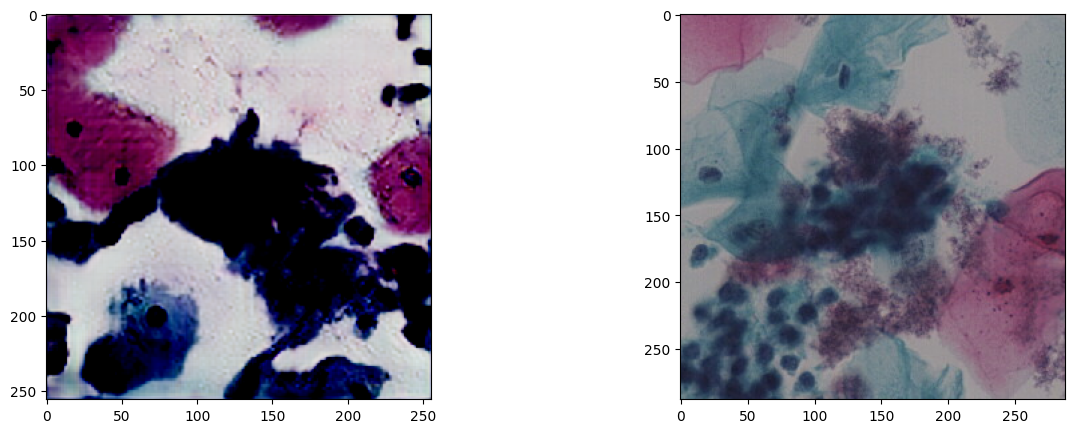

In [77]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(gen_img_numpy[0].transpose(1, 2, 0))

plt.subplot(122)
plt.imshow(sim_img)